In [48]:
from sklearn.feature_selection import mutual_info_regression 
from sklearn.feature_selection import SelectPercentile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline
sns.set(style='darkgrid', rc={'figure.figsize':(10,6)})

import warnings
warnings.filterwarnings("ignore")

In [49]:
df=pd.read_csv('depression_dataset.csv')
df.shape

(1007, 21)

In [50]:
def data_preparation(data):

    data=data.drop(['Timestamp'],axis=1)
    data=data.drop(['Have you done any recreational activity (sports, gaming, hobby etc.) today?'],axis=1)
    data=data.set_index('Which year are you in?')
    data_numeric=data.drop(data.iloc[:, [0,2,4,5,6,8,9,10,11,12,13,14,15,16]],axis=1)
    data_non_numeric=data.drop(data.iloc[:, [1,3,7,17]],axis=1)
    le=LabelEncoder()
    encode=data_non_numeric.apply(le.fit_transform)
    return pd.concat([encode,data_numeric],axis=1)
 

# Data Preparation

In [51]:
data_final=data_preparation(df)
data_final.shape

(1007, 18)

In [52]:
data_final.dtypes

How are you feeling right now?                                                                  int64
Gender                                                                                          int64
Your location ?                                                                                 int64
Relationship status                                                                             int64
Are you happy with your financial state?                                                        int64
Understanding with your family members?                                                         int64
Are you feeling pressure in your study or work right now?                                       int64
Are you satisfied with your academic result?                                                    int64
Are you happy with your living place?                                                           int64
Who supports you when you are not succeeding in your academic life?               

# Feature Selection

In [79]:
def important_features_visualization_linear(data):

    X=data.drop('On a scale of 1-100, how would you express this feeling?',axis=1)
    y=data['On a scale of 1-100, how would you express this feeling?']
    imp=mutual_info_regression(X,y)
    feat_imp=pd.Series(imp,data.columns[0:len(data.columns)-1])
    feat_imp.sort_values(ascending=False).plot(kind='barh',color='teal',figsize=(20,10))
    plt.show()

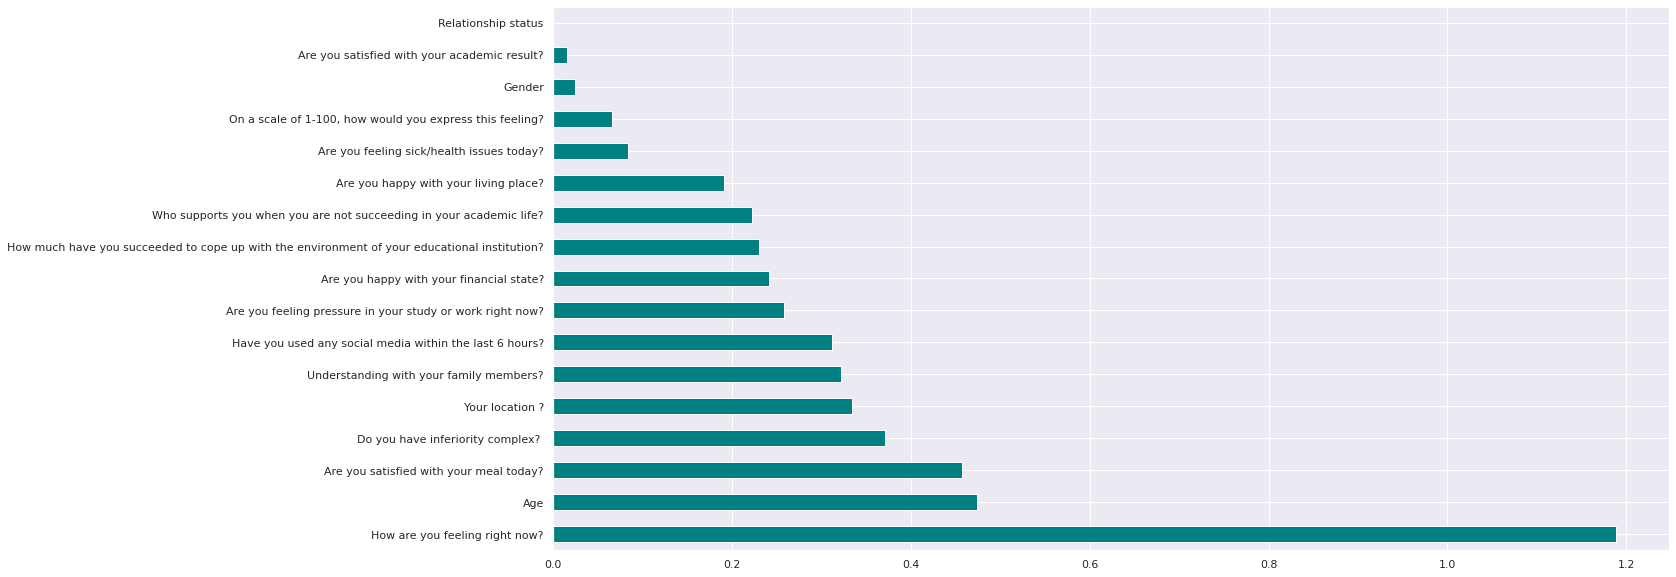

In [81]:
imp_feat_vis=important_features_visualization_linear(data_final)
imp_feat_vis

In [55]:
def feature_selection_linear(data):

    X=data.drop('On a scale of 1-100, how would you express this feeling?',axis=1)
    y=data['On a scale of 1-100, how would you express this feeling?']
    select=SelectPercentile(mutual_info_regression,percentile=30)
    select.fit(X,y)
 
    return X.columns[select.get_support()]

In [60]:
important_features=feature_selection_linear(data_final)
important_features

Index(['How are you feeling right now?', 'Your location ?',
       'Do you have inferiority complex? ',
       'Are you satisfied with your meal today?',
       'How much have you succeeded to cope up with the environment of your educational institution?'],
      dtype='object')

# Splitting the Data based on the Feature Selection

In [61]:
X=data_final[['Do you have inferiority complex? ','How are you feeling right now?', 'Are you satisfied with your meal today?', 'Your location ?', 'How much have you succeeded to cope up with the environment of your educational institution?']].values
y=data_final['On a scale of 1-100, how would you express this feeling?'].values

In [62]:
from sklearn.model_selection import train_test_split

In [63]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=21)

In [64]:
mean_y = np.mean(y_test)

# Linear Regression from Scratch

### <span style='color:green'>***Step-1***</span>***:*** <span style='color:red'>***Initialize the Parameters which are weight and bias***</span>

In [65]:
def initialize_parameters(lenw):
    """The numpy.random.randn() function creates an array of specified shape and fills it with random values as per standard 
    normal distribution.
    
    Arg: 
       lenw: n numbers of training samlple i.e. X_train.shape[0]
    Returns:
          weight and bias
    """
    w=np.random.randn(1, lenw)
    b=0
    return w, b

### <span style='color:green'>***Step-2***</span>***:*** <span style='color:red'>***Forward Propagation***</span>

In [66]:
def forward_prop(X, w, b):
    """A linear function or prediction function which is the matrix multiplication of the training samples and weights and then 
    sum up the bias.
    
    Args:
        X: X_train
        w, b: weights and bias from the step 1.
    Returns:
          z: The result of the calculation
    """
    y_pred=np.dot(w, X)+b
    return y_pred

### <span style='color:green'>***Step-3***</span>***:*** <span style='color:red'>***Cost Function***</span>

In [67]:
def cost_function(y_pred, y):
    """Cost function  is (1/2) of mean squared error.
    
    Args:
        y_pred: Prediction funtion
        y: True value
    Returns: 
        J: Cost function
    """
    m=y.shape[1]
    J=(1/(2*m))*np.sum(np.square(y_pred-y))
    return J

### <span style='color:green'>***Step-4***</span>***:*** <span style='color:red'>***Backward Propagation***</span>

In [68]:
# row vector mul with col vec. (1xm)x(mxn)=(1xn). Rows are transposed into cols
def back_prop(X, y, y_pred):
    """Finds the derivative of weight's and bias's.
    
    Args:
        X: Independent variables
        y: Dependent variables
        y_pred: Found from prediction function
    Returns:
        dw, db: Derivative of weight's and bais's
    """
    m=y.shape[1]
    dy_pred=(1/m)*(y_pred-y)
    dw=np.dot(dy_pred, X.T)
    db=np.sum(dy_pred)
    return dw, db

### <span style='color:green'>***Step-5***</span>***:*** <span style='color:red'>***Gradient Descent***</span>

In [69]:
def gradient_descent(w, b, dw, db, lr):
    """Update of weight and bias.
    
    Args:
        w, b, dw, db, lr: Old weights and bias's with their derivatives and learning rate(lr)
    Returns:
        w, b: Updated weight and bias
    """
    w=w-lr*dw
    b=b-lr*db
    return w, b

In [70]:
def linear_regression_model(X_train, y_train, X_test, y_test, lr, epochs):
    """This function puts all the 5 steps altogether and builds the linear regreesion model from scratch.
    
    Args:
       Training and testing data with a learning rate(lr) and iteration(epochs)
    Returns:
        Training and testing costs and mean absolute errors and also plots them.
    """
    lenw=X_train.shape[0]
    w, b=initialize_parameters(lenw) #step1
    costs_train=[]
    costs_test=[]
    MAEs_train=[]
    MAEs_test=[]
    m_train=y_train.shape[1]
    m_test=y_test.shape[1]
    
    for i in range(1,epochs+1):
        #training set
        y_pred_train=forward_prop(X_train, w, b) #step2
        cost_train=cost_function(y_pred_train, y_train) #step3
        dw, db=back_prop(X_train, y_train, y_pred_train) #step4
        w, b=gradient_descent(w, b, dw, db, lr) #step5
        
        if i%10==0:
            costs_train.append(cost_train)
        MAE_train=(1/m_train)*np.sum(np.abs(y_pred_train-y_train))
        if i%10==0:
            MAEs_train.append(MAE_train)
        
        #testing set
        y_pred_test=forward_prop(X_test, w, b)
        
        cost_test=cost_function(y_pred_test, y_test)
        if i%10==0:
            costs_test.append(cost_test)
        MAE_test=(1/m_test)*np.sum(np.abs(y_pred_test-y_test))
        if i%10==0:
            MAEs_test.append(MAE_test)
        
        print('Epochs '+str(i)+' /'+str(epochs)+': ')
        print('Training Cost '+str(cost_train)+'|'+' Testing Cost '+str(cost_test))
        print('Training MAE '+str(MAE_train)+'|'+' Testing MAE '+str(MAE_test))
    
    plt.plot(costs_train, color='orange', label='Training Cost')
    plt.plot(costs_test, color='blue', label='Testing Cost')
    plt.xlabel('Iterations (per 10)', fontsize=18)
    plt.ylabel('Cost', fontsize=18)
    plt.title('Learning Rate '+str(lr), fontsize=18)
    plt.legend(prop={'size': 15})
    plt.tight_layout()
    plt.show();
    
    plt.plot(MAEs_train, color='orange', label='Training Mean absolute Error')
    plt.plot(MAEs_test, color='blue', label='Testing Mean absolute Error')
    plt.xlabel('Iterations (per 10)', fontsize=18)
    plt.ylabel('Mean absolute Error', fontsize=18)
    plt.title('Learning Rate '+str(lr), fontsize=18)
    plt.legend(prop={'size': 15})
    plt.tight_layout()
    plt.show();

# Scaling the Independent Features

In [71]:
def normalize(X):
    """Scaling the independent variables.
    
    Arg:
       X: Training and testing independent variables
    Returns:
       Normalized variables
    """
    X=(X-X.mean())/(X.max()-X.min())
    return X

In [72]:
X_train=normalize(X_train)
X_test=normalize(X_test)

# Reshaping the Data for the Model

In [73]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((805, 5), (805,), (202, 5), (202,))

In [74]:
def reshaping(train_x, train_y, test_x, test_y):
    """For Linear Regression model, it requires X_train, X_test=(n_features x n_training_samples) and
                                                   y_train, y_test=(1 x m_train where m_train=n_training_samples)
    So reshaping the data.
    
    Args:
        Takes the training and testing samples
    Returns:
        Reshaped data
    """
    train_x=train_x.T
    train_y=np.array([train_y])
    test_x=test_x.T
    test_y=np.array([test_y])
    
    return train_x, train_y, test_x, test_y

In [75]:
X_train, y_train, X_test, y_test=reshaping(X_train, y_train, X_test, y_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5, 805), (1, 805), (5, 202), (1, 202))

# Calling the Raw Model

Epochs 1 /300: 
Training Cost 2138.977956301749| Testing Cost 793.7945929270562
Training MAE 60.18445177552704| Testing MAE 34.945838767705844
Epochs 2 /300: 
Training Cost 814.783934821102| Testing Cost 426.80889322049813
Training MAE 35.917097820184054| Testing MAE 27.064176803709394
Epochs 3 /300: 
Training Cost 435.6597310280721| Testing Cost 323.8845460066871
Training MAE 27.527924599032733| Testing MAE 23.034430833602052
Epochs 4 /300: 
Training Cost 325.68169775369813| Testing Cost 294.37576728090704
Training MAE 23.125066946292538| Testing MAE 20.872015582336154
Epochs 5 /300: 
Training Cost 292.4161142476296| Testing Cost 284.8597679373638
Training MAE 20.823214844924365| Testing MAE 19.74130261237471
Epochs 6 /300: 
Training Cost 281.07345437078664| Testing Cost 280.5853820369733
Training MAE 19.655786272096947| Testing MAE 19.241462954452075
Epochs 7 /300: 
Training Cost 276.0502834816203| Testing Cost 277.59790140909183
Training MAE 19.135419285519685| Testing MAE 18.998478

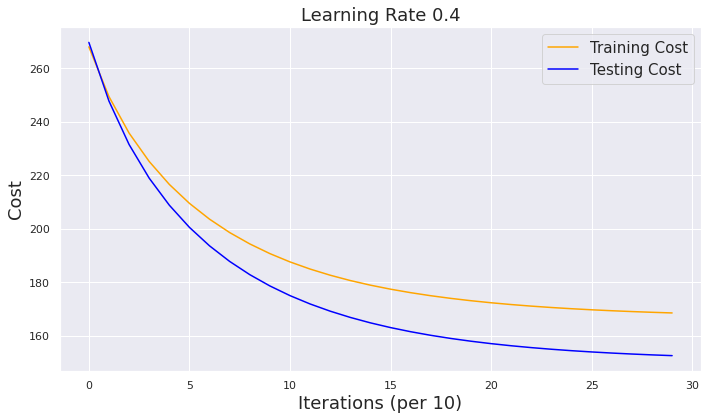

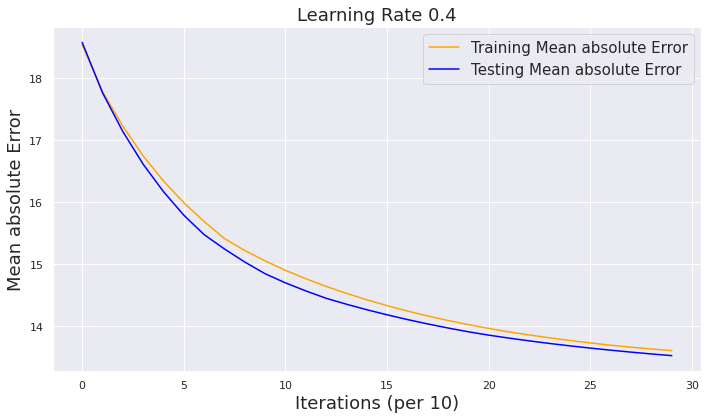

In [76]:
linear_regression_model(X_train, y_train, X_test, y_test, lr=0.4, epochs=300)

In [77]:
def sklearn_linear_regression(x_train, y_train, x_test, y_test):
    """This function is for creating the model using the bult-in function in sklearn.
    
    Args:
        Training and testing data
    Returns:
        Mean absolute Error for training and testing
    """
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_absolute_error,r2_score
    model=LinearRegression()
    model.fit(x_train.T, y_train.T)
    predictions_train=model.predict(x_train.T)
    predictions_test=model.predict(x_test.T)

    print('Mean absolute error: %.2f'
      % mean_absolute_error(y_test.T, predictions_test))
    print('r2 score: %.2f'
      % r2_score(y_test.T, predictions_test))

In [78]:
sklearn_linear_regression(X_train, y_train, X_test, y_test)

Mean absolute error: 13.14
r2 score: 0.56
